In [1]:
using ITensors
using LaTeXStrings
using Plots
using Zygote
using Zygote: @ignore, @adjoint, pullback
using LinearAlgebra

In [2]:
function Tmat(J::ElTJ,g::ElTG, N::Int64) where{ElTJ <: Real, ElTG <: Real}
    elt = promote_type(ElTJ,ElTG)
    T = SymTridiagonal(fill!(Array{elt}(undef, N), -2*g), fill!(Array{elt}(undef, N-1), -J))
    return T
end
function Dmat(J::ElTJ,N::Int64) where{ ElTJ <: Real}
    off_diag = fill!(Array{ElTJ}(undef, N-1), J)
    D = Tridiagonal(off_diag,zeros(ElTJ, N), -1 .* off_diag)
    return D
end
function BdGHam(J,g,N::Int64)
    H = zeros(2*N,2*N)
    
    T = Tmat(J,g,N)
    D = Dmat(J,N)
    
    H[1:N,1:N] = T
    H[N+1:end,N+1:end] = -T
    H[1:N,N+1:end] = D
    H[N+1:end,1:N] = -D
    return H
end

BdGHam (generic function with 1 method)

In [3]:
struct MPS_comp{A <: MPS, L<:Real}
    ψ::A
    λ::L
    function MPS_comp(ψ::A; λ::L=0.0) where{A <: MPS, L <: Real}
        return new{A,L}(ψ, λ)
    end
    function MPS_comp(ψ::A, λ::L) where{A <: MPS, L <: Real}
        return new{A,L}(ψ, λ)
    end
end

import Base: +, -, *
+(this::MPS_comp, other::MPS_comp) = MPS_comp(psi(this) + psi(other), lambda(this) + lambda(other))
-(this::MPS_comp) = MPS_comp(-psi(this), -lambda(this))
-(this::MPS_comp, other::MPS_comp) = MPS_comp(psi(this) - psi(other), lambda(this)-lambda(other))
*(scalar, this::MPS_comp) = MPS_comp(scalar*psi(this), scalar*lambda(this))
*(this::MPS_comp, scalar) = scalar*this

psi(obj::MPS_comp) = obj.ψ
lambda(obj::MPS_comp) = obj.λ
vectorize(obj::MPS_comp) = [obj.ψ, obj.λ]

function Base.copy(obj::MPS_comp)
    ψc = copy(psi(obj))
    λc = copy(lambda(obj))
    return MPS_comp(ψc, λc)
end

import LinearAlgebra: norm
#norm2(obj::MPS_comp, p::Real = 2) = sqrt(norm(psi(obj), p)^2 + lambda(obj)^2)

function norm(obj::MPS_comp, p::Real=2)
    if p == Inf
        n_psi = norm(psi(obj), Inf)
        n_lambda = abs(lambda(obj))
        return n_psi > n_lambda ? n_psi : n_lambda
    elseif p == 0
        n_psi = norm(psi(obj), 0)
        n_lambda = isapprox(lambda(obj), 0) ? 0 : 1
        return n_psi + n_lambda
    elseif p == -Inf
        n_psi = norm(psi(obj), -Inf)
        n_lambda = abs(lambda(obj))
        return n_psi > n_lambda ? n_lambda : n_psi
    else
        (norm(psi(obj), p)^p + lambda(obj)^p)^(1/p)
    end
end

import ITensors: inner, normalize

inner(this::MPS_comp, other::MPS_comp) = inner(psi(this), psi(other)) + lambda(this)*lambda(other)
squared_norm(obj::Union{MPS_comp, MPS}) = inner(obj,obj)



normalize(obj::MPS_comp) = MPS_comp(normalize(psi(obj)), lambda(obj))

########## Adjoints ##################
@adjoint psi(obj::MPS_comp)    = obj.ψ, ψ̄ -> (MPS_comp(ψ̄, 0.0),)
@adjoint function lambda(obj::MPS_comp) 
    new_ten = similar(psi(obj))

    for (jj, T) in enumerate(psi(obj))
        new_ten[jj] = fill!(similar(T), 0)
    end
    
    return obj.λ, λ̄ -> (MPS_comp(new_ten, λ̄),)
end


@adjoint function MPS_comp(ψ::A, λ::L) where{A <: MPS, L <: Real}
    return MPS_comp(ψ, λ), p̄ -> (p̄.ψ, p̄.λ)
end

Zygote.refresh()


In [4]:
#=
let
    s = siteinds("S=1/2",10)
    psi0 = randomMPS(s)
    λ0 = 1.0
    ψc = MPS_comp(psi0, λ0)
    
    ham_ising = ham(0.6,1, s);

    f = x -> en_func(x, ham_ising)
    ∇f= x -> gradient(f, x)[1]

    grad1 = ∇f(ψc)
    norm(grad1, Inf) |> display
    norm(psi(grad1), Inf) |> display
    x_n_p = ψc - grad1
    x_n   = copy(ψc)  
    
    ψ_n = psi(x_n)
    ψ_n_p = psi(x_n_p)
    λ_n = lambda(x_n)
    λ_n_p = lambda(x_n_p)
    
    
    abs(inner(ψ_n - ψ_n_p, psi(grad1)) + (λ_n - λ_n_p)*(lambda(grad1))) |> display
    abs(inner(x_n - x_n_p, grad1))
    
    b = false
    a = begin b = true; 3 end
    println(b)
    println(a)
    
    5.0 * grad1
    normalize(ψc)
end
=#

In [5]:
struct GD_problem{A <: Union{MPS_comp, MPS}, R <: Real}
    
    # problem structure, contains information regarding the problem
    
    f # the objective function
    ∇f # objective gradient
    x0::A # the intial condition
    γ::R # the stepsize
    
end

struct GD_setting
    
    # user settings to solve the problem using Gradient Descent
    
    γ::Float64 # the step size
    maxit::Int64 # maximum number of iteration
    tol::Float64 # tolerance, i.e., if ||∇f(x)|| ≤ tol, we take x to be an optimal solution
    verbose::Bool # whether to print information about the iterates
    freq::Int64 # how often print information about the iterates

    # constructor for the structure, so if user does not specify any particular values, 
    # then we create a GD_setting object with default values
    function GD_setting(; γ = 1, maxit = 1000, tol = 1e-8, verbose = false, freq = 10)
        new(γ, maxit, tol, verbose, freq)
    end
    
end

mutable struct GD_state{T <: Union{MPS_comp, MPS}, I <: Integer, R <: Real} # contains information regarding one iterattion sequence
    
    x::T    # iterate x_n
    ∇f_x::T # one gradient ∇f(x_n)
    γ::R # stepsize
    n::I # iteration counter
    finish::Bool
    
end

function GD_state(problem::GD_problem)
    
    # a constructor for the struct GD_state, it will take the problem data and create one state containing all 
    # the iterate information, current state of the gradient etc so that we can start our gradient descent scheme
    
    # unpack information from iter which is GD_iterable type
    x0 = copy(problem.x0) # to be safe
    f = problem.f
    γ = problem.γ
    ∇f_x = ∇f(x0)
    n = 1
    finish = false
    
    return GD_state(x0, ∇f_x, γ, n, finish)
    
end

function GD_iteration!(problem::GD_problem, state::GD_state; tol = eps())
    
    # this is the main iteration function, that takes the problem information, and the previous state, 
    # and create the new state using Gradient Descent algorithm
    
    # unpack the current state information
    #ψ_n = psi(state.x)
    #λ_n = lambda(state.x)
    x_n = state.x
    ∇f_x_n = state.∇f_x
    
    γ_n = state.γ
    n = state.n
    
    # compute the next state
    #ψ_n_p = ψ_n - γ_n*∇f_x_n[1]
    #λ_n_p = λ_n - γ_n*∇f_x_n[2]
    #x_n_p = MPS_comp(ψ_n, λ_n)
    x_n_p = x_n - γ_n*∇f_x_n
    
    # now load the computed values in the state
    state.x = normalize(x_n_p)
    #state.∇f_x = problem.∇f([ψ_n_p, λ_n_p])
    state.∇f_x = problem.∇f(x_n_p)
    #f_x = problem.f([ψ_n_plus_1, λ_n_plus_1]) # note that f_x is not used anywhere
    
    
    tmp = ∇f_x_n - state.∇f_x
    tmpnormsq = squared_norm(tmp)
    state.γ = sqrt(tmpnormsq) > tol ? abs(inner(x_n - x_n_p, tmp))/tmpnormsq : 
                begin state.finish = true; 0.0 end
    
        
    #=
    state.γ = tmpnorm > tol ? abs(inner(ψ_n - ψ_n_p, tmp[1]) 
                                   + (λ_n - λ_n_p)*(tmp[2]))/
                                (inner(tmp[1],tmp[1]) + tmp[2]^2) : 
                state.finish = true
    =#
    
    #state.γ = 1/(n+1)
    state.n = n+1
    
    # done computing return the new state
    return state
    
end

function GD_solver(problem::GD_problem, setting::GD_setting)
    
    # this is the function that the end user will use to solve a particular problem, internally it is using the previously defined types and functions to run Gradient Descent Scheme
    # create the intial state
    state = GD_state(problem)
    
    ## time to run the loop
    while  (!state.finish && state.n < setting.maxit) && (norm(state.∇f_x, Inf) > setting.tol)
        # compute a new state
        state =  GD_iteration!(problem, state, tol = settings.tol)
        # print information if verbose = true
        if setting.verbose == true
            if mod(state.n, setting.freq) == 0
                #@info "iteration = $(state.n) | obj val = $(problem.f([state.x, state.λ])) | gradient norm = $(norm(state.∇f_x, Inf))"
                @info "iteration = $(state.n) | obj val = $(problem.f(state.x)) | gradient norm = $(norm(state.∇f_x, Inf))"
            end
        end
    end
    
    # print information regarding the final state
    
    #@info "final iteration = $(state.n) | final obj val = $(problem.f([state.x, state.λ])) | final gradient norm = $(norm(state.∇f_x, Inf))"
    @info "final iteration = $(state.n) | final obj val = $(problem.f(state.x)) | final gradient norm = $(norm(state.∇f_x, Inf))"
    return state
    
end

GD_solver (generic function with 1 method)

In [6]:
function ham(J, g, sites)
    ampo = OpSum()
    N = length(sites)
    for j=1:N-1
      ampo += J*4,"Sx",j,"Sx",j+1
      ampo += g*2, "Sz",j
    end
    ampo += g*2, "Sz",N
    H = MPO(ampo,sites)
end

ham (generic function with 1 method)

In [7]:
function en_func(psi, ham; psi_opt::Union{Nothing, Vector{MPS}} = nothing, w = 100)
    psic = nothing
    @ignore psic = copy(psi)
    nrmsq = inner(psi, psic)
    # @show nrmsq
    overlap = inner(psi', ham, psic)
    isnothing(psi_opt) || (overlap += w*sum(map(x -> abs(inner(psi, x)), psi_opt)))
    return overlap/nrmsq
end

function en_func(ψc::MPS_comp, ham; psi_opt::Union{Nothing, Vector{MPS}} = nothing, w = 100)
    psicop = nothing
    @ignore psicop = copy(ψc)
    nrmsq = inner(psi(ψc), psi(psicop))
    overlap = inner(psi(ψc)', ham, psi(psicop)) - lambda(ψc)*(nrmsq - 1)
    return overlap
end

en_func (generic function with 2 methods)

In [8]:
n = 10
J = 1
g = 0
s = siteinds("S=1/2",n)
ψ0 = normalize(randomMPS(s))
#λ0 = 1.0
#ψ0c = MPS_comp(ψ0, λ0)


ham_ising = ham(J,g, s);
γ = 1.0

f = x -> en_func(x, ham_ising)
#f = x -> en_func(x[1], x[2], ham_ising)
∇f= x -> gradient(f, x)[1]
#∇∇f = x -> gradient((squared_norm ∘ ∇f), x)[1]

problem = GD_problem(f, ∇f, ψ0, γ)
settings = GD_setting(maxit = 5000)


state_f = GD_solver(problem, settings)
#psi_f = psi(final_state_GD.x)
#λ_f = lambda(final_state_GD.x)


ψgs = state_f.x;
en_func(ψ0, ham_ising)/n |> display
en_func(ψgs, ham_ising)/n |> display
ψstates = [ψgs];

[ Info: final iteration = 36 | final obj val = -8.999999999999893 | final gradient norm = 1.7320508075688776


0.3780436983575208

-0.8999999999999894

In [9]:
#=
norm(ψ_f)^2 - 1 |> display
#λ_f |> display
inner(ψ_f', ham_ising, ψ_f) |> display
println(final_state_GD.∇f_x[2])
println(ψ_f[2])
println(norm(ψ_f - ψ_f))
=#

In [10]:
n_ex = 4
ψstates = #Vector{MPS}(undef, n_ex)
ψstates = [ψgs]
for n in 1:n_ex
    ψ0 = randomMPS(s)
    γ = 1.0
    f = x -> en_func(x, ham_ising, psi_opt = ψstates, w = 100)
    ∇f= ψ -> gradient(f, ψ)[1]
    
    problem  = GD_problem(f, ∇f, ψ0, γ)
    settings = GD_setting(maxit = 1000)

    state_f = GD_solver(problem, settings)
    ψ_f_ex  = state_f.x
    println("Final Energy: $(en_func(ψ_f_ex, ham_ising))")
    push!(ψstates, ψ_f_ex)
end

Final Energy: -8.999972110287235


[ Info: final iteration = 1000 | final obj val = 28.47814397635506 | final gradient norm = 74.31138941191999


Final Energy: -7.031679048898622


[ Info: final iteration = 1000 | final obj val = 7.090770665735996 | final gradient norm = 105.37529523380853


Final Energy: -7.019522874330857


[ Info: final iteration = 1000 | final obj val = 13.405115650044822 | final gradient norm = 150.14612376385503


Final Energy: -6.7477149877547795


[ Info: final iteration = 1000 | final obj val = -6.406334829065053 | final gradient norm = 222.9061363770857


In [11]:
energies = map(x -> en_func(x, ham_ising)/n, ψstates) # normalized expectation values of the energies for site (n)
for (jj,(ψ,E)) in enumerate(zip(ψstates, energies))
    println("Energy of ψ_$jj: $(E)")
    nrms = map(x -> inner(ψ, x), ψstates)
    println("Norm between ψ_$jj and all other states: $(nrms)")
end

Energy of ψ_1: -0.8999999999999894
Norm between ψ_1 and all other states: [1.000000000000001, -0.37478116086642377, -0.07237279687439498, 0.06866753127119642, -0.0019165722627111199]
Energy of ψ_2: -0.8999972110287235
Norm between ψ_2 and all other states: [-0.3747811608664235, 1.0000000000000016, -0.06885170027195125, 0.04904566530311079, 0.0003484660010642426]
Energy of ψ_3: -0.7031679048898621
Norm between ψ_3 and all other states: [-0.07237279687439503, -0.06885170027195134, 1.0000000000000016, -0.08653318866944995, 0.0005728045876313972]
Energy of ψ_4: -0.7019522874330857
Norm between ψ_4 and all other states: [0.06866753127119632, 0.04904566530311078, -0.08653318866944981, 1.0000000000000007, -0.0005759587354903881]
Energy of ψ_5: -0.6747714987754779
Norm between ψ_5 and all other states: [-0.0019165722627111593, 0.00034846600106425206, 0.0005728045876314228, -0.0005759587354904178, 0.9999999999999986]


In [12]:
vals = eigvals(BdGHam(J,g,n))

E0 = 1/2*sum(vals[vals.<0])
e0 = E0/10
ex_en = vals[vals.>=0];
ex_energies = similar(energies)
ex_energies[1] = e0
ex_energies[2:end] = (E0 .+ ex_en[1:n_ex]) ./ n

4-element Vector{Float64}:
 -0.9
 -0.9
 -0.7000000000000002
 -0.7

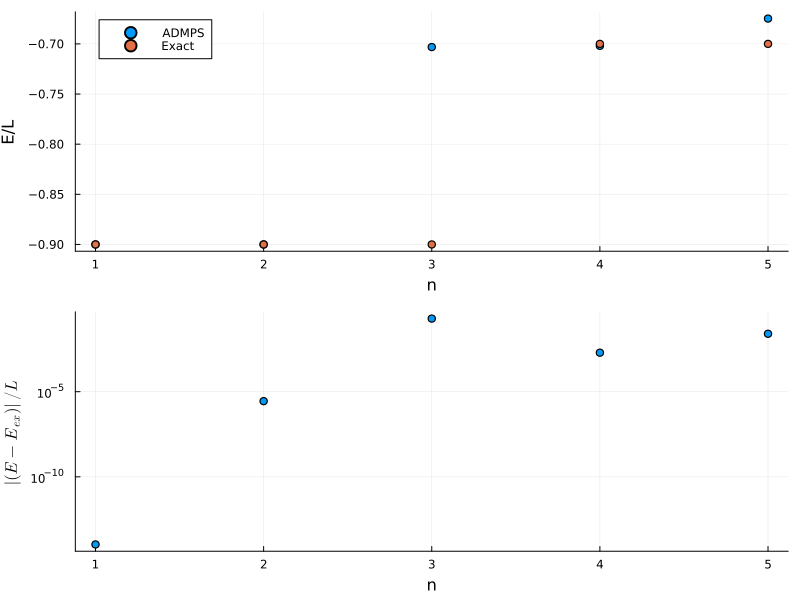

In [13]:
p1 = plot([energies ex_energies], seriestype = :scatter, label = ["ADMPS" "Exact"], legend = :topleft)
xlabel!(p1, "n")
ylabel!(p1, "E/L")
p2 = plot(abs.(energies .- ex_energies), seriestype = :scatter, legend = false, yscale = :log10)
xlabel!(p2, "n")
ylabel!(p2, L"|(E - E_{ex})|/L")


pc = plot(p1,p2, size = (800,600), layout = (2,1))
savefig(pc, "excited_states_TFI_para.pdf")
display(pc)